In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import sympy as sym

import inputs
import models
import shooting

from __future__ import division

### Welcome to the Estimation notebook!

This notebook defines some workers and firms - usign parameters obtained from Distributions.ipynb - solves for a first run of the model and then uses the estimation code to get the sum of squared residuals between data (taken from PD05_wage.csv) and the implied functions of the model: mu(x), theta(x), w(x)

In [5]:
# define some default workers skill
x, mu1, sigma1 = sym.var('x, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((x - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'mu1':1.0000000000000002, 'sigma1': 0.16382221849787501}
skill_bounds = [1e-2, 1.4991086434]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some default firms
y, mu2, sigma2 = sym.var('y, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((y - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'mu2':1.0000000000000002, 'sigma2':0.26979838777863219}
productivity_bounds = [0.0921194652671, 1.95530939088]

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for Cobb-Douglas between l and r
l, r, omega_B, sigma_B = sym.var('l, r, omega_B, sigma_B')
B = l**omega_B * r**(1 - omega_B)

F = A * B

F_params = {'omega_A':0.75, 'omega_B':0.4, 'sigma_A':0.6, 'sigma_B':1.0}

model = models.Model('positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

solver = shooting.ShootingSolver(model=model)

** Now that everything is defined, let's try to solve the model once first! **

This will give us a good idea about inital guesses and number of knots.

In [79]:
solver.solve(2.3, tol=1e-6, number_knots=6000, atol=1e-15, rtol=1e-12, integrator='lsoda', message=True)

Exhausted workers: initial guess of 1.15 for firm size is too high!
Exhausted firms: initial guess of 0.575 for firm size is too low.
Exhausted workers: initial guess of 0.8625 for firm size is too high!
Exhausted workers: initial guess of 0.71875 for firm size is too high!
Exhausted workers: initial guess of 0.646875 for firm size is too high!
Exhausted firms: initial guess of 0.6109375 for firm size is too low.
Exhausted workers: initial guess of 0.62890625 for firm size is too high!
Exhausted firms: initial guess of 0.619921875 for firm size is too low.
Exhausted firms: initial guess of 0.6244140625 for firm size is too low.
Exhausted workers: initial guess of 0.62666015625 for firm size is too high!
Exhausted firms: initial guess of 0.625537109375 for firm size is too low.
Exhausted firms: initial guess of 0.626098632812 for firm size is too low.
Exhausted firms: initial guess of 0.626379394531 for firm size is too low.
Exhausted workers: initial guess of 0.626519775391 for firm si

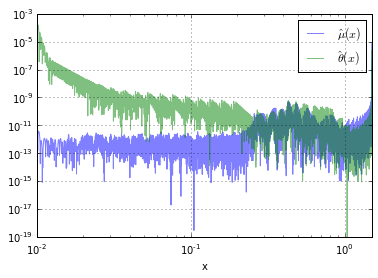

In [63]:
# Plotting the residuals
solver.residuals.plot(loglog=True, alpha=0.5)
plt.show()

In [64]:
solver.solution.head()

,$\mu(x)$,$\theta(x)$,$w(x)$,$\pi(x)$
x,,,,
0.010000,0.09212,1468.064101,0.000069,0.152977
0.010248,0.09212,1386.802385,0.000074,0.152977
0.010496,0.09212,1311.909642,0.000078,0.152977
0.010745,0.09212,1242.750075,0.000082,0.152977
0.010993,0.09212,1178.764261,0.000087,0.152977


** Time to import the estimation_code **

In [7]:
import estimation_code_norm as est

Now we can try if the objective function works:

In [8]:
# Starting, arbitrary parameters
ps = (0.75, 0.4, 0.6)

# Reading data from csv file
xs, ys, thetas, ws = est.import_data('data05_normed.csv', ID=False)

# Worker skill parameters are taken from Histograms.ipynb - and correspond to log wages mean and variance
skill_p = (1.0000000000000002, 0.16382221849787501)
skill_b = [1e-2, 1.4991086434]

#skill_p = (3.8894753094349528, 0.63718247398434291)
#skill_b = [0.01, 340.6127]

# Firm skill parameters are also taken from Histograms.ipynb - and correspond to log profit mean and variance (firm level)
firm_p = (1.0000000000000002, 0.26979838777863219)
firm_b = [0.0921194652671, 1.95530939088]

#firm_p = (7.13768801209, 1.92573671813)
#firm_b = [1.93, 1151284.0]

# Run!
est.ObjectiveFunction(ps, (xs, ys, thetas, ws), skill_p, skill_b, firm_p, firm_b, 2.3)

Success! All workers and firms are matched


688.28791072062995

Or try the two functions individually:

In [81]:
# SolveModel
functions, new_guess = est.Solve_Model(F, F_params, workers, firms, 'positive', 6000.0, 'lsoda', 2.3)
mu_hat, theta_hat, w_hat = functions

Success! All workers and firms are matched


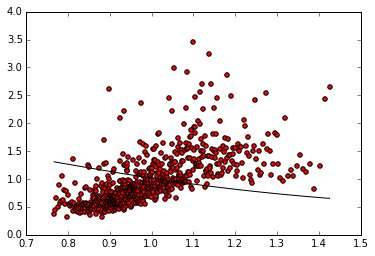

In [82]:
# Plotting the function vs the data (some fit better than others)
mus1 = []
xs_copy = np.sort(xs)
for i in range(len(xs_copy)):
    mus1.append(theta_hat(xs_copy[i]))
plt.plot(xs_copy, mus1, c='black')
plt.scatter(xs, thetas, c='r')
#plt.xlim(0,10)
#plt.ylim(0,500)
plt.show()

In [ ]:
# Checking the mean square error - actually, the sum of squared errors of mu(x), theta(x), w(x)
est.Calculate_MSE( (xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat) )

## Iterate for some parameters

## $\omega_b$

In [18]:
h_theta = 100
results9 = np.zeros(2)
bad_result9 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':0.75, 'omega_B':om, 'sigma_A':0.6, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results9 = np.vstack((results9,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result9 = np.vstack((bad_result9,results_i))
        print 'Skipped error', om
        pass


Success! All workers and firms are matched
Done with 0.9
Success! All workers and firms are matched
Done with 0.85
Success! All workers and firms are matched
Done with 0.8
Success! All workers and firms are matched
Done with 0.75
Success! All workers and firms are matched
Done with 0.7
Success! All workers and firms are matched
Done with 0.65
Success! All workers and firms are matched
Done with 0.6
Success! All workers and firms are matched
Done with 0.55
Success! All workers and firms are matched
Done with 0.5
Success! All workers and firms are matched
Done with 0.45
Success! All workers and firms are matched
Done with 0.4
Skipped error 0.35
Skipped error 0.3
Skipped error 0.25
Skipped error 0.2
Skipped error 0.15
Skipped error 0.1


In [ ]:
h_theta = 100
results10 = np.zeros(2)
bad_result10 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':0.25, 'omega_B':om, 'sigma_A':0.6, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results10 = np.vstack((results10,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result10 = np.vstack((bad_result10,results_i))
        print 'Skipped error', om
        pass


Skipped error 0.9
Skipped error 0.85
Success! All workers and firms are matched
Done with 0.8
Success! All workers and firms are matched
Done with 0.75
Success! All workers and firms are matched
Done with 0.7
Success! All workers and firms are matched
Done with 0.65
Success! All workers and firms are matched
Done with 0.6
Success! All workers and firms are matched
Done with 0.55
Success! All workers and firms are matched
Done with 0.5
Success! All workers and firms are matched
Done with 0.45
Success! All workers and firms are matched
Done with 0.4
Skipped error 0.35
Skipped error 0.3
Skipped error 0.25
Skipped error 0.2
Skipped error 0.15
Skipped error 0.1


In [ ]:
h_theta = 100
results11 = np.zeros(2)
bad_result11 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':0.75, 'omega_B':om, 'sigma_A':0.3, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results11 = np.vstack((results11,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result11 = np.vstack((bad_result11,results_i))
        print 'Skipped error', om
        pass


Success! All workers and firms are matched
Done with

In [ ]:
h_theta = 100
results12 = np.zeros(2)
bad_result12 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':0.25, 'omega_B':om, 'sigma_A':0.3, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results12 = np.vstack((results12,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result12 = np.vstack((bad_result12,results_i))
        print 'Skipped error', om
        pass


## $\omega_a$

In [ ]:
h_theta = 100
results1 = np.zeros(2)
bad_result1 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':om, 'omega_B':0.75, 'sigma_A':0.6, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results1 = np.vstack((results1,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result1 = np.vstack((bad_result1,results_i))
        print 'Skipped error', om
        pass


In [ ]:
h_theta = 100
results2 = np.zeros(2)
bad_result2 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':om, 'omega_B':0.25, 'sigma_A':0.6, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results2 = np.vstack((results2,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result2 = np.vstack((bad_result2,results_i))
        print 'Skipped error', om
        pass


In [ ]:
h_theta = 100
results3 = np.zeros(2)
bad_result3 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':om, 'omega_B':0.25, 'sigma_A':0.3, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results3 = np.vstack((results3,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result3 = np.vstack((bad_result3,results_i))
        print 'Skipped error', om
        pass


In [ ]:
h_theta = 100
results4 = np.zeros(2)
bad_result4 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':om, 'omega_B':0.75, 'sigma_A':0.3, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results4 = np.vstack((results4,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result4 = np.vstack((bad_result4,results_i))
        print 'Skipped error', om
        pass


## $\sigma$

In [ ]:
h_theta = 100
results5 = np.zeros(2)
bad_result5 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':0.75, 'omega_B':0.75, 'sigma_A':om, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results5 = np.vstack((results5,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result5 = np.vstack((bad_result5,results_i))
        print 'Skipped error', om
        pass


In [ ]:
h_theta = 100
results6 = np.zeros(2)
bad_result6 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':0.75, 'omega_B':0.25, 'sigma_A':om, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results6 = np.vstack((results6,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result6 = np.vstack((bad_result6,results_i))
        print 'Skipped error', om
        pass


In [ ]:
h_theta = 100
results7 = np.zeros(2)
bad_result7 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':0.25, 'omega_B':0.75, 'sigma_A':om, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results7 = np.vstack((results7,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result7 = np.vstack((bad_result7,results_i))
        print 'Skipped error', om
        pass


In [ ]:
h_theta = 100
results8 = np.zeros(2)
bad_result8 = np.zeros(2)
for om in np.arange(0.9,0.05,-0.05):
    params_i = {'omega_A':0.25, 'omega_B':0.25, 'sigma_A':om, 'sigma_B':1.0}
    try:
        # Solving Phase
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        err = (est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        # Storage phase
        results_i = np.hstack((om,err))        
        results8 = np.vstack((results8,results_i))
        # Update phase
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        results_i = np.hstack((om,'Failure'))
        bad_result8 = np.vstack((bad_result8,results_i))
        print 'Skipped error', om
        pass


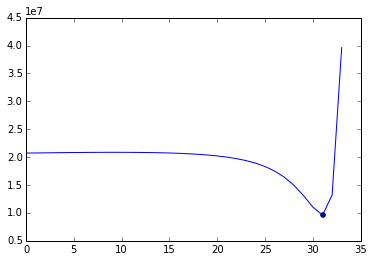

Best result: 9608553.88584 ; Omega: 0.4


In [115]:
plt.plot(results_i[:-5])
plt.xlim(0,35)
plt.scatter(results_i.index(min(results_i)), min(results_i))
plt.show()
print "Best result:",min(results_i),"; Omega:",0.4

### Appendix

In [ ]:
# Pottentially useful bit of code
rxs = solver.solution.index.values
rmus = solver.solution['$\\mu(x)$'].values
rthetas = solver.solution['$\\theta(x)$'].values
rws = solver.solution['$w(x)$'].values